In [1]:
from matplotlib import pyplot as plt
import numpy as np
import qutip as qt

In [2]:
def gaussian_ramp(initial_time, t0, amplitude):
    """
    Creates a time-dependent function using a Gaussian function that starts near zero,
    peaks at 'amplitude' at time 't0', and remains constant at 'amplitude' for t > t0.

    Args:
    t0 (float): The time at which the function peaks at the amplitude.
    amplitude (float): The maximum amplitude of the Gaussian peak.

    Returns:
    function: A function of time 't' that implements the desired behavior.
    """
    # Define the standard deviation such that the peak is sharp at t0
    sigma = t0 / 3  # Adjust sigma to make the function start close to zero at t=0

    # Define the function using a closure to encapsulate the parameters
    def time_dependent_function(t):
        t_mid = initial_time / 2  # Middle point of the time range
        t_rise = t0  # Time for rising edge
        t_fall = initial_time - t0  # Time for falling edge
        
        if t <= t_rise:
            # Gaussian rise centered at t_rise
            return amplitude * np.exp(-((t - t_rise)**2) / (2 * sigma**2)) - amplitude * np.exp(-((0 - t_rise)**2) / (2 * sigma**2))
        elif t >= t_fall:
            # Gaussian fall centered at t_fall
            return amplitude * np.exp(-((t - t_fall)**2) / (2 * sigma**2)) - amplitude * np.exp(-((initial_time - t_fall)**2) / (2 * sigma**2))
        else:
            # Constant amplitude in the middle region
            return amplitude - amplitude * np.exp(-((0 - t_rise)**2) / (2 * sigma**2))


    return time_dependent_function


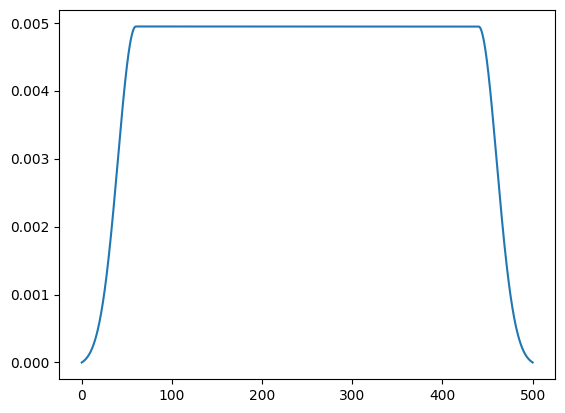

In [20]:
tlist = np.linspace(0, 500, 100000)  # Cover ten periods
func = gaussian_ramp(500,60, 0.005* 2 * np.pi)
plt.plot(tlist,[func(t)/2/np.pi for t in tlist])

lab frame

rotating frame

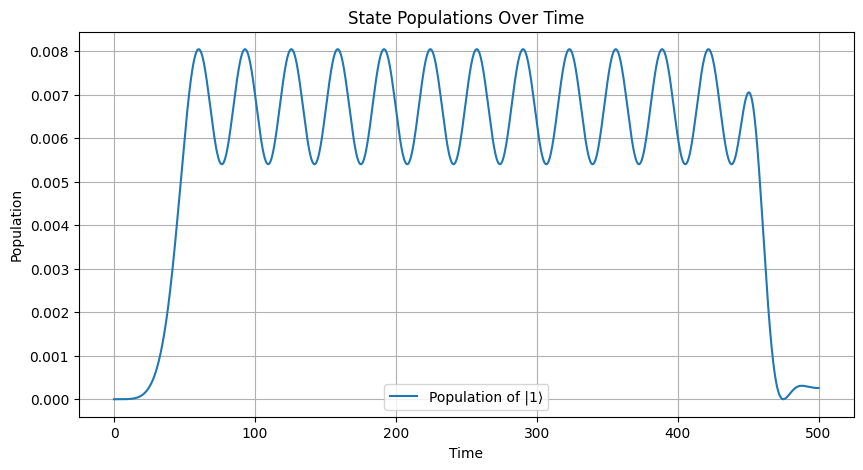

In [21]:
omega = 6.03 * 2 * np.pi
omega1 = 6.06*2*np.pi
T = (2*np.pi)/omega
args = {'w': omega,'w1':omega1}
tlist = np.linspace(0, 500, 10000)  # Cover ten periods
psi0 = qt.basis(2, 0)
H0 = (omega-omega1)/2*qt.sigmaz()
Hc = qt.sigmax()
H = [H0, [Hc, lambda t, args: func(t)/2]]
options = {"nsteps":100000, "rtol":1e-10, "atol":1e-10}

# Use sesolve for consistency with previous code
result = qt.sesolve(H, psi0, tlist, args=args, options=options)

# Calculate populations directly from result states
pop0_rwa = [abs(state[0])**2 for state in result.states]
pop1_rwa = [abs(state[1])**2 for state in result.states]

# Plot results
plt.figure(figsize=(10, 5))
# plt.plot(tlist, pop0_rwa, label="Population of |0⟩")
plt.plot(tlist, pop1_rwa, label="Population of |1⟩")
plt.xlabel("Time")
plt.ylabel("Population")
plt.title("State Populations Over Time")
plt.legend()
plt.grid(True)
plt.show()

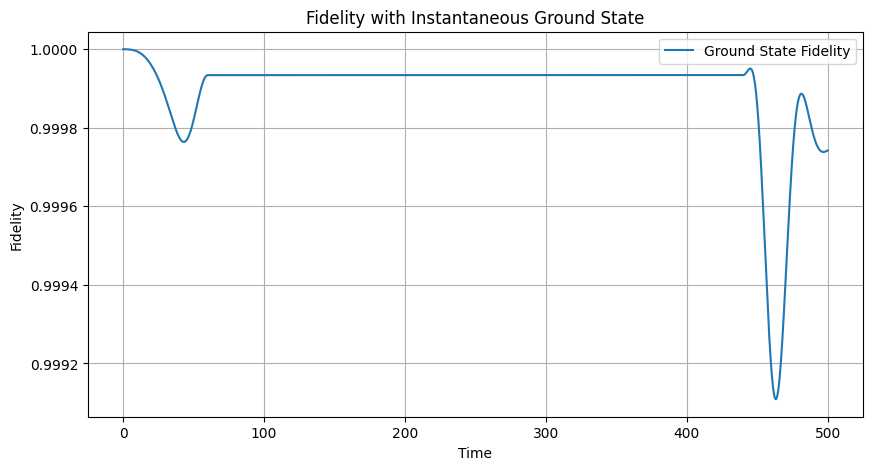

In [22]:
T = (2*np.pi)/omega
args = {'w': omega,'w1':omega1}
tlist = np.linspace(0, 500, 10000)  # Cover ten periods
psi0 = qt.basis(2, 0)
H0 = (omega-omega1)/2*qt.sigmaz()
Hc = qt.sigmax()
H = [H0, [Hc, lambda t, args: func(t)/2]]
options = {"nsteps":100000, "rtol":1e-10, "atol":1e-10}
result = qt.sesolve(H, psi0, tlist, args=args, options=options)

# Calculate instantaneous eigenstates for each time point
fidelities = []
evecs_list = []  # Store all eigenvectors
for t, state in zip(tlist, result.states):
    # Construct instantaneous Hamiltonian
    H_t = H0 + Hc * func(t)/2
    # Get eigenvalues and eigenvectors
    evals, evecs = H_t.eigenstates()
    evecs_list.append(evecs)  # Store eigenvectors for this time point
    # Ground state is the eigenstate with lowest energy
    ground_state = evecs[0]
    # Calculate fidelity between evolved state and ground state
    fidelity = abs((ground_state.dag() * state))**2
    fidelities.append(fidelity)

# Plot fidelities vs time
plt.figure(figsize=(10, 5))
plt.plot(tlist, fidelities, label='Ground State Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity with Instantaneous Ground State')
plt.legend()
plt.grid(True)
plt.show()


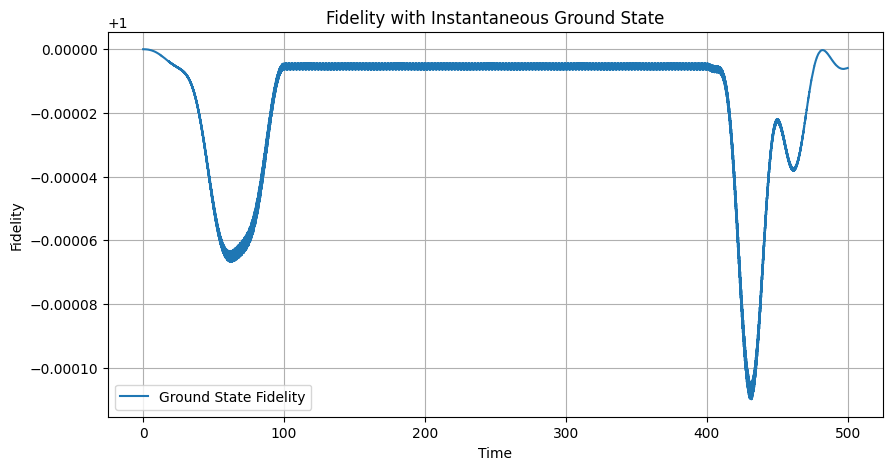

In [63]:
T = (2*np.pi)/omega
args = {'w': omega,'w1':omega1}
tlist = np.linspace(0, 500, 10000)  # Cover ten periods
psi0 = qt.basis(2, 0)
H0 = (omega)/2*qt.sigmaz()
Hc = qt.sigmax()
H = [H0, [Hc, lambda t, args: func(t)*np.cos(args['w1']*t)]]
options = {"nsteps":100000, "rtol":1e-10, "atol":1e-10}
result = qt.sesolve(H, psi0, tlist, args=args, options=options)
evecs_list = []  # Store all eigenvectors
# Calculate instantaneous eigenstates for each time point
fidelities = []
for i in range(len(tlist)):
    H_t = (omega-omega1)/2*qt.Qobj(np.array([[1,0],[0,-1]])) + Hc * func(tlist[i])/2
    # Get eigenvalues and eigenvectors
    evals, evecs = H_t.eigenstates()
    evecs_list.append(evecs)  # Store eigenvectors for this time point
    # Ground state is the eigenstate with lowest energy
    ground_state = evecs[0]
    # We don't need to recalculate evecs as they are given from the previous cell
    # Just use the corresponding time point's eigenvectors from evecs_list
    # Ground state is the eigenstate with lowest energy
    state = result.states[i]
    # Calculate fidelity between evolved state and ground state
    ground_state = evecs_list[i][0]
    U = (1j/2 * omega1 * tlist[i] * qt.sigmaz()).expm()
    fidelity = abs((ground_state.dag() * U * state))**2
    fidelities.append(fidelity)

# Plot fidelities vs time
plt.figure(figsize=(10, 5))
plt.plot(tlist, fidelities, label='Ground State Fidelity')
plt.xlabel('Time')
plt.ylabel('Fidelity')
plt.title('Fidelity with Instantaneous Ground State')
plt.legend()
plt.grid(True)
plt.show()
